In [1]:
from itertools import combinations
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

from neurodsp.sim import sim_variable_oscillation, sim_powerlaw
from neurodsp.utils.norm import normalize_sig
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.plts import plot_time_series

from fooof import FOOOF
from fooof.sim.gen import gen_periodic

from ndspflow.motif import Motif
from ndspflow.optimize import refit

## Polynomial Transformations 
### Improved Motif to Cycle Registration

This notebook explores the use of the polynomial transformation of a motif (i.e. a sinusoid) into each cycles. These transformations are applied to simulations with dynamically modulated rise-decay symmetry. The idea is that a good registration framework will provide features (e.g. transformation matrix) that tracks the modulation in the simulated signal.

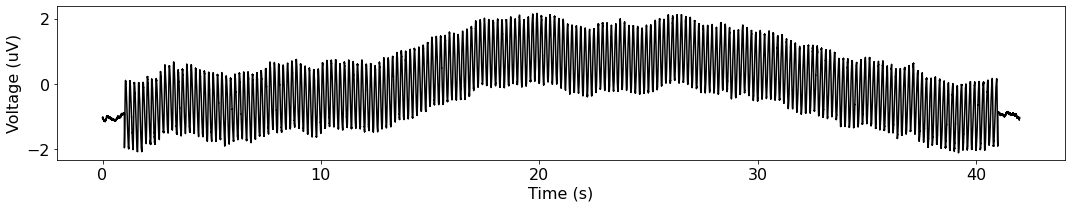

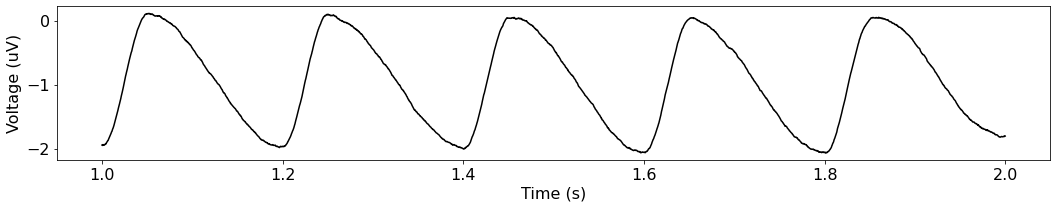

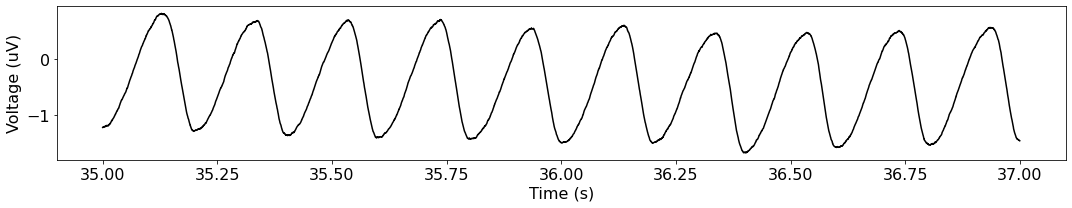

In [2]:
np.random.seed(0)

# Simulate different rdsyms at 8, 10, and 12 hz
fs = 5000 
freq = 5

#rdsym = np.concatenate((np.repeat(.2, 50), np.repeat(.8, 50)))
rdsym = np.linspace(.25, .75, 200)

_sig_osc = sim_variable_oscillation(None, fs, freq, cycle='asine',
                                    rdsym=rdsym, phase='min')

sig_pl = sim_powerlaw(1, len(_sig_osc)+int(2*fs), exponent=-2)
sig_osc = np.zeros_like(sig_pl)
sig_osc[fs:-fs] = _sig_osc

#sig_osc = np.pad(normalize_sig(sig_osc, 0, .4), fs)
#sig_pl = np.pad(normalize_sig(sig_pl, 0, .2), fs)
sig_osc = normalize_sig(sig_osc, 0, .5)
sig_pl = normalize_sig(sig_pl, 0, .5)
sig = sig_osc + sig_pl

# Plot
times = np.arange(0, len(sig)/fs, 1/fs)
plot_time_series(times, sig)

plot_time_series(times[fs:2*fs], sig[fs:2*fs])
plot_time_series(times[35*fs:37*fs], sig[35*fs:37*fs])

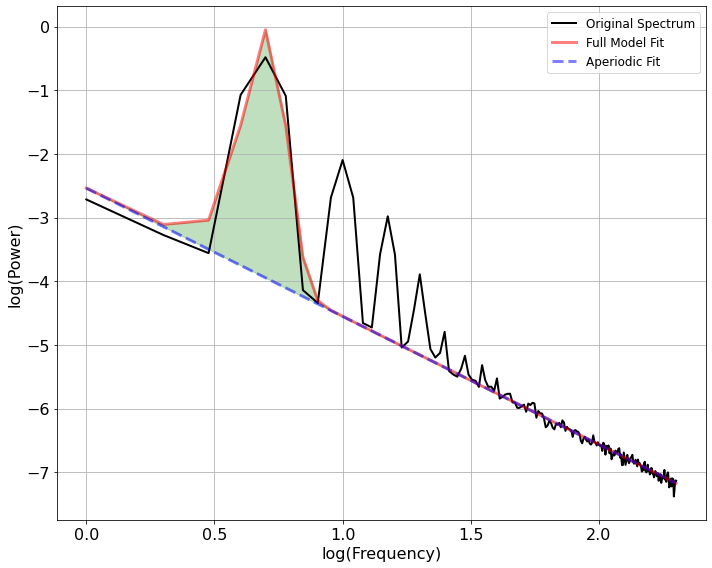

In [3]:
# Get spectrum
f_range = (1, 200)
freqs, powers = compute_spectrum(sig, fs, f_range=f_range)

# SpecParam
fm = FOOOF(verbose=False)
fm.fit(freqs, powers, f_range)

# Refit spectral using the HHT to ignore harmonics
fm_refit, imfs, mask = refit(fm, sig, fs, f_range, energy_thresh=.1)
fm_refit.plot(plot_peaks='shade', plt_log=True)

# Fit a single motif
motif = Motif(max_clusters=1)
motif.fit(fm_refit, sig, fs, round_samples=-2)
motif.decompose()

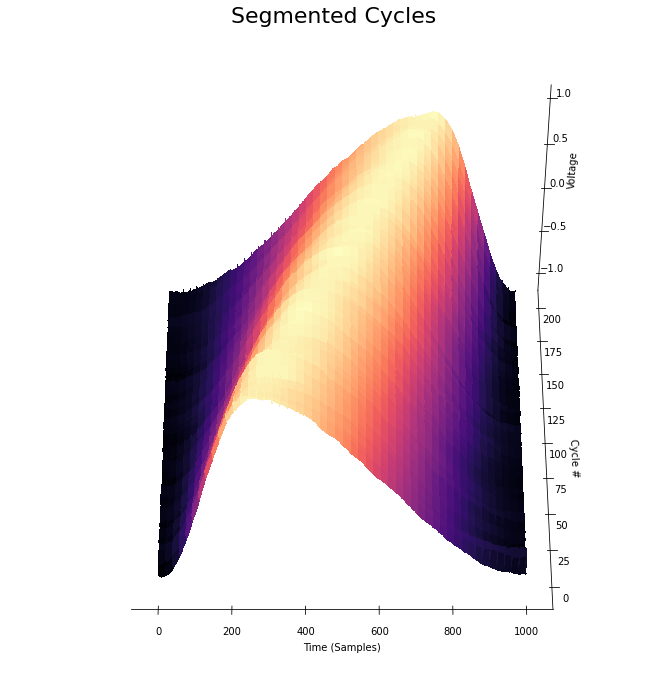

In [4]:
# Set arrays
_cycles = motif[0].sigs
_motif = np.tile(motif[0].motif[0], (len(motif[0].sigs), 1))

n_samples_cycles = len(_motif[0])
xs = np.arange(n_samples_cycles)

# Plot
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": "3d"})

x = np.tile(np.arange(len(_motif[0])), (len(_motif), 1))
y = np.tile(np.arange(len(x)), (len(_motif[0]), 1)).T

ax.plot_surface(x, y, _cycles, cmap=plt.cm.magma,
                linewidth=.1, antialiased=False)

ax.set_xlabel('Time (Samples)')
ax.set_ylabel('Cycle #')
ax.set_zlabel('Voltage')

ax.view_init(50, -90)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_title('Segmented Cycles', size=22);

### Polynomial Transformation

Scikit-image's PolynomialTransfomation is optimized using the TRF algorithm as implemented in scipy's curve_fit. This allows a single motif to be moved into each cycle's space using 12 parameters per cycle (polynomial order=2). The transformation parameters are highly correlated with the simulate rise-decay symmetry, as expected.

In [5]:
from scipy.optimize import curve_fit
from functools import partial
from skimage.transform import PolynomialTransform

def poly_fit(xs, *params, src_ys=None):
    
    tform = PolynomialTransform(np.array(params).reshape(2, -1))
    
    ys_fit = tform(np.column_stack((xs, src_ys)))[:, 1]

    return ys_fit

# Fit
src = np.column_stack((xs, _motif[0]))
dst = np.column_stack((xs, _cycles[0]))

In [6]:
n_params = 12

bounds = [
    [-100] * n_params,
    [ 100] * n_params
]

guess = [-1] * n_params


sig_pe = np.zeros_like(sig)

inds = np.arange(fs, len(sig)-fs, n_samples_cycles)
params = np.zeros((len(inds), 12))
cycles_fit = np.zeros((len(inds), n_samples_cycles))

for i in range(len(inds)):
    
    a = motif[0].motif[0]
    b = sig[inds[i]:inds[i]+n_samples_cycles]
    
    
    pfunc = partial(poly_fit, src_ys=a)
    _params, _ = curve_fit(pfunc, np.arange(n_samples_cycles), b,
                           p0=guess, bounds=bounds, maxfev=10000)
    
    tform = PolynomialTransform(np.array(_params).reshape(2, -1))
    tform = tform(np.column_stack((np.arange(n_samples_cycles), a)))
    
    ys_fit = tform[:, 1]
    ys_fit = ys_fit - ys_fit.mean()
    cycles_fit[i] = ys_fit
    
    sig_pe[inds[i]:inds[i]+n_samples_cycles] = ys_fit

    params[i] = _params

sig_ap = sig-sig_pe

Text(0.5, 0.92, 'Motif Transformed to Cycles')

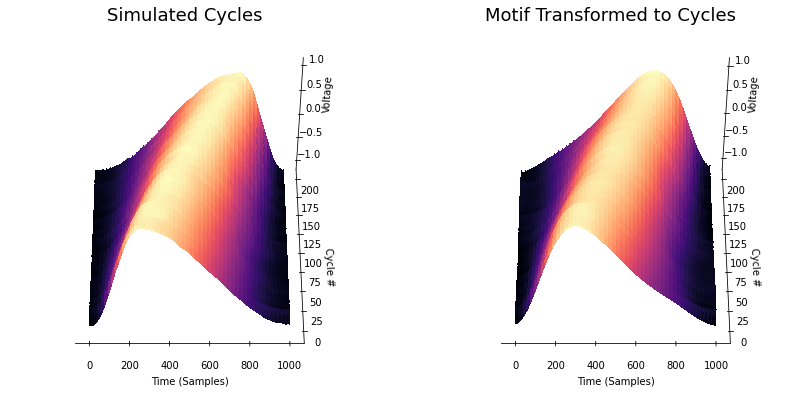

In [7]:
# Set arrays
_cycles = motif[0].sigs
_motif = np.tile(motif[0].motif[0], (len(motif[0].sigs), 1))

n_samples_cycles = len(_motif[0])
xs = np.arange(n_samples_cycles)

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(14, 14), subplot_kw={"projection": "3d"})

x = np.tile(np.arange(len(_motif[0])), (len(_motif), 1))
y = np.tile(np.arange(len(x)), (len(_motif[0]), 1)).T

axes[0].plot_surface(x, y, _cycles, cmap=plt.cm.magma,
                     linewidth=.1, antialiased=False)

axes[1].plot_surface(x, y, cycles_fit, cmap=plt.cm.magma,
                     linewidth=.1, antialiased=False)

for ax in axes:
    
    ax.set_xlabel('Time (Samples)')
    ax.set_ylabel('Cycle #')
    ax.set_zlabel('Voltage')

    ax.view_init(50, -90)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

axes[0].set_title('Simulated Cycles', size=18)
axes[1].set_title('Motif Transformed to Cycles', size=18)

In [8]:
print('R-Values: rdsym vs polynomial parameters\n')

rvalues = np.array([np.corrcoef(rdsym, p)[0][1] for p in params.T[1:]])
print(rvalues.round(2))

R-Values: rdsym vs polynomial parameters

[-0.11 -0.1   0.13 -0.05 -0.04 -0.81  0.84 -0.98  0.05  0.99 -0.02]


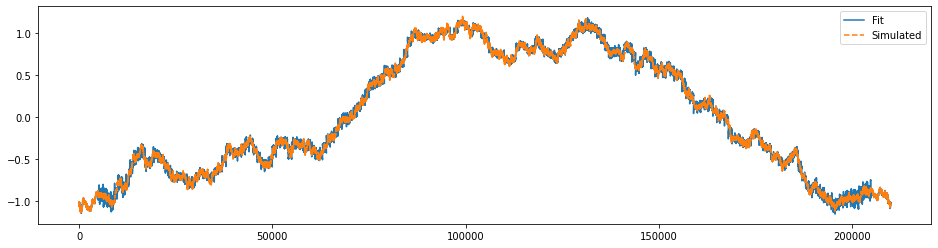

In [9]:
plt.figure(0, figsize=(16, 4))
plt.plot(sig_ap, label='Fit')
plt.plot(sig_pl, ls='--', label='Simulated')
plt.legend();

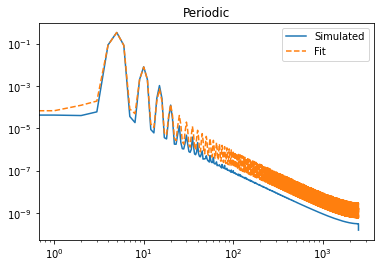

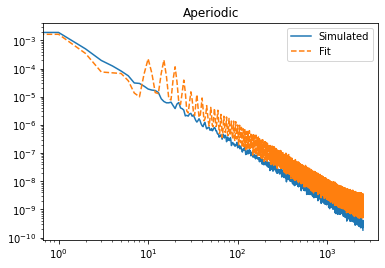

In [10]:
plt.figure(0)
plt.title('Periodic')

f, p = compute_spectrum(sig_osc, fs)
plt.loglog(f, p, label='Simulated')

f, p = compute_spectrum(sig_pe, fs)
plt.loglog(f, p, ls='--', label='Fit')

plt.legend();

plt.figure(1)
plt.title('Aperiodic')

f, p = compute_spectrum(sig_pl, fs)
plt.loglog(f, p, label='Simulated')

f, p = compute_spectrum(sig_ap, fs)
plt.loglog(f, p, ls='--', label='Fit')

plt.legend();